In [1]:
from datasets import load_dataset
import torch

In [ ]:
!pip install datasets

In [2]:
dataset = load_dataset(
    "RitAreaSciencePark/imagenet_short_text_100_classes_x_100_samples", split="train"
)
print(len(dataset))

10000


205


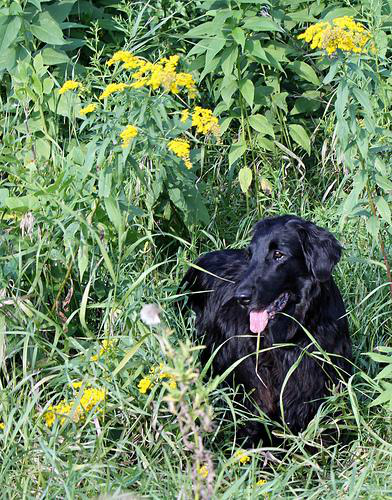

In [6]:
data = dataset[9999] #215 category picture 
print(data["label"])
data["image"]

In [ ]:
from transformers import ViTImageProcessor, ViTForImageClassification

#make processor n image classification
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224").eval()

In [ ]:
!pip install transformers

In [9]:
inputs = processor(images=data["image"], return_tensors="pt") # train the image
outputs = model(**inputs) # put in the output

probs = torch.softmax(outputs.logits, dim=-1) # make prob to with raw score dim-1 

In [10]:
probs.shape

torch.Size([1, 1000])

In [ ]:
topn = 5 # get top 5 only
id2label = model.config.id2label # get label name

values, indices = probs.view(-1).sort(descending=True) # make prob
values = values.tolist()[:topn] #get value
indices = indices.tolist()[:topn] # get indecs

for value, index in zip(values, indices):
    print(f"{index}, {id2label[index]}: {value}")

205, flat-coated retriever: 0.9171034693717957
206, curly-coated retriever: 0.04684550315141678
214, Gordon setter: 0.016294173896312714
197, giant schnauzer: 0.003979409579187632
256, Newfoundland, Newfoundland dog: 0.0034733531065285206


In [ ]:

#lead data set
dataset = load_dataset("pasindu/google_conceptual_captions_20000", split="train")

In [13]:

#get random shuffle data
dataset = dataset.shuffle()
dataset = dataset.take(1000)

In [14]:
image = dataset[0]["image_data"]

In [ ]:
from transformers import ViTModel

#put data in VitModel
model = ViTModel.from_pretrained("google/vit-base-patch16-224").eval()

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np
from tqdm import tqdm

vectors = [] # store vector embedded
image_paths = [] # img file path
image_idx = 0 

for data in tqdm(dataset):
    try:
        image = data["image_data"] # extract image from sample
        inputs = processor(images=image, return_tensors="pt") # perform on data, resize, normalize, covert to sensor
    except ValueError:
        continue

    with torch.inference_mode(): # disable gradient mode
        outputs = model(**inputs, output_hidden_states=True)  # make output final layer
        hidden_states = outputs.last_hidden_state[0, 0, :].numpy() # extract token embedding,represent entire image

        vectors.append(hidden_states) # append to list

        path = f"images/{image_idx}.{image.format.lower()}"
        image.save(path)
        image_paths.append(path)
        image_idx += 1

vectors = np.stack(vectors) # make matrix

100%|██████████| 1000/1000 [05:49<00:00,  2.86it/s]


In [19]:
vectors.shape

(987, 768)

In [ ]:
from sklearn.manifold import TSNE

# use tsne to reduce dimension for embeded data
tsne = TSNE(n_components=2, max_iter=1000, perplexity=20, random_state=42) # dimension reduce
embeddings = tsne.fit_transform(vectors)

In [21]:
from bokeh.plotting import figure, show
from bokeh.io import output_file
from bokeh.models import ColumnDataSource, HoverTool

output_file("tsne_image_hover.html")

source = ColumnDataSource(
    # on hover to get image data
    data=dict(x=embeddings[:, 0], y=embeddings[:, 1], images=image_paths)
)

# make scatter with hover
p = figure(title="t-SNE Image Hover Example", width=720, height=560)
p.scatter("x", "y", source=source, size=8, alpha=0.7)

hover = HoverTool(
    tooltips="""<img src="@images" style="height: 100px;" alt="image"/>"""
)
p.add_tools(hover)

show(p)